In [26]:
# data handling
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import random_split

# plotting
import matplotlib.pyplot as plt

# network
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary
from torchvision.utils import save_image
import torchvision
import torch.optim as optim



In [2]:
def show_images(dataset, num_images=9):
    figure, axes = plt.subplots(3, 3, figsize=(5, 5))  # Creates a grid of 3x3 subplots
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        # Randomly pick an image from the dataset
        img, label = dataset[torch.randint(len(dataset), size=(1,)).item()]
        img = img.squeeze()  # Remove the channel dimension
        ax.imshow(img, cmap='gray')  # Plot the image in grayscale
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()


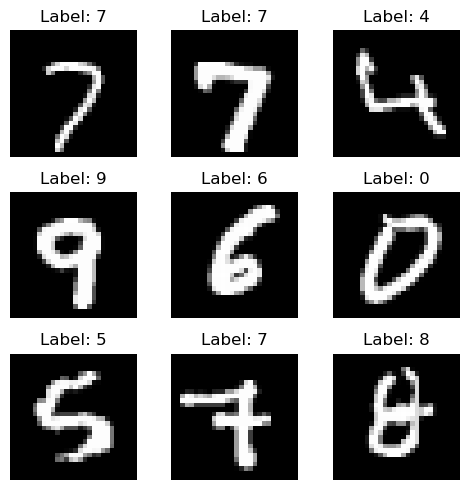

In [3]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(0.5, 0.5)           # Normalize to [-1, 1]
    #transforms.Normalize((0.1307,), (0.3081,))  # Normalize using mean and std
])

dataset = datasets.MNIST(root='MNIST', train=True, download=True, transform=transform)
show_images(dataset, num_images=3)

# Split into training and validation sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 64*4
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [62]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim=400):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784 + label_dim, hidden_dim) #784 = 28*28 (flattened MNIST dataset)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) #784 = 28*28 (flattened MNIST dataset)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)  # Mean
        self.fc32 = nn.Linear(hidden_dim, latent_dim)  # Log-variance

    def forward(self, x, labels):
        x = torch.cat([x, labels], dim=1)
        h1 = F.relu(self.fc1(x))
        h2 = self.fc2(h1)
        return self.fc31(h2), self.fc32(h2)

class Decoder(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim=400):
        super(Decoder, self).__init__()
        self.fc4 = nn.Linear(latent_dim + label_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, 784)

    def forward(self, z, labels):
        z = torch.cat([z, labels], dim=1)
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        return torch.sigmoid(self.fc6(h5))

class CVAE(nn.Module):
    def __init__(self, latent_dim, label_dim, hidden_dim=400):
        super(CVAE, self).__init__()
        self.encoder = Encoder(latent_dim, label_dim, hidden_dim=400)
        self.decoder = Decoder(latent_dim, label_dim, hidden_dim=400)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, log_var = self.encoder(x, labels)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z, labels), mu, log_var

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


In [63]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.epochs_no_improve} out of {self.patience}')
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.epochs_no_improve = 0


Epoch: 1 - Current Learning Rate: 0.001
====> Epoch: 1 Average training (validation) loss: 204.7862 (164.1294)
Epoch: 2 - Current Learning Rate: 0.001
====> Epoch: 2 Average training (validation) loss: 147.3164 (137.1351)
Epoch: 3 - Current Learning Rate: 0.001
====> Epoch: 3 Average training (validation) loss: 129.2908 (125.4858)
Epoch: 4 - Current Learning Rate: 0.001
====> Epoch: 4 Average training (validation) loss: 121.0820 (118.9180)
Epoch: 5 - Current Learning Rate: 0.001
====> Epoch: 5 Average training (validation) loss: 116.5170 (115.6772)


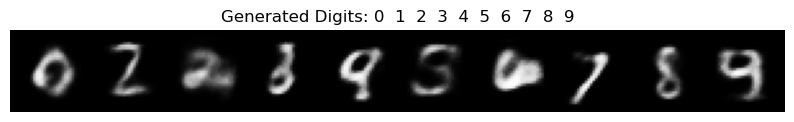

Epoch: 6 - Current Learning Rate: 0.001
====> Epoch: 6 Average training (validation) loss: 113.2537 (113.4737)
Epoch: 7 - Current Learning Rate: 0.001
====> Epoch: 7 Average training (validation) loss: 110.8478 (111.1094)
Epoch: 8 - Current Learning Rate: 0.001
====> Epoch: 8 Average training (validation) loss: 108.8019 (109.1031)
Epoch: 9 - Current Learning Rate: 0.001
====> Epoch: 9 Average training (validation) loss: 107.1686 (107.7068)
Epoch: 10 - Current Learning Rate: 0.001
====> Epoch: 10 Average training (validation) loss: 105.7984 (107.3068)


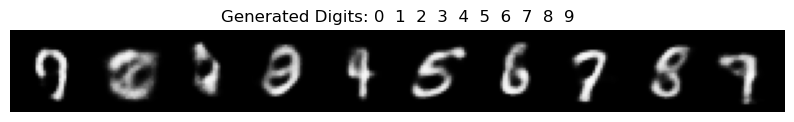

Epoch: 11 - Current Learning Rate: 0.001
====> Epoch: 11 Average training (validation) loss: 104.5981 (105.3653)
Epoch: 12 - Current Learning Rate: 0.001
====> Epoch: 12 Average training (validation) loss: 103.4392 (104.6103)
Epoch: 13 - Current Learning Rate: 0.001
====> Epoch: 13 Average training (validation) loss: 102.6020 (103.1867)
Epoch: 14 - Current Learning Rate: 0.001
====> Epoch: 14 Average training (validation) loss: 101.7327 (102.8747)
Epoch: 15 - Current Learning Rate: 0.001
====> Epoch: 15 Average training (validation) loss: 101.1084 (102.7708)


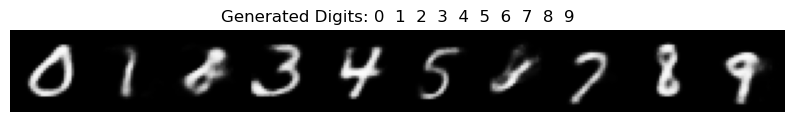

Epoch: 16 - Current Learning Rate: 0.001
====> Epoch: 16 Average training (validation) loss: 100.5442 (102.7595)
Epoch: 17 - Current Learning Rate: 0.001
====> Epoch: 17 Average training (validation) loss: 100.0318 (101.5697)
Epoch: 18 - Current Learning Rate: 0.001
====> Epoch: 18 Average training (validation) loss: 99.5247 (101.2859)
Epoch: 19 - Current Learning Rate: 0.001
====> Epoch: 19 Average training (validation) loss: 99.1518 (101.0772)
Epoch: 20 - Current Learning Rate: 0.001
====> Epoch: 20 Average training (validation) loss: 98.8103 (100.3695)


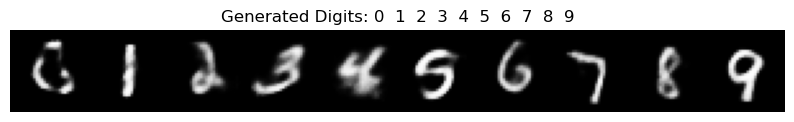

Epoch: 21 - Current Learning Rate: 0.001
====> Epoch: 21 Average training (validation) loss: 98.4704 (100.7705)
EarlyStopping counter: 1 out of 5
Epoch: 22 - Current Learning Rate: 0.001
====> Epoch: 22 Average training (validation) loss: 98.1275 (99.9346)
Epoch: 23 - Current Learning Rate: 0.001
====> Epoch: 23 Average training (validation) loss: 97.8230 (99.5960)
Epoch: 24 - Current Learning Rate: 0.001
====> Epoch: 24 Average training (validation) loss: 97.5849 (99.7435)
EarlyStopping counter: 1 out of 5
Epoch: 25 - Current Learning Rate: 0.001
====> Epoch: 25 Average training (validation) loss: 97.3116 (99.7815)
EarlyStopping counter: 2 out of 5


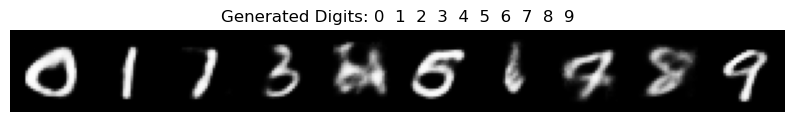

Epoch: 26 - Current Learning Rate: 0.001
====> Epoch: 26 Average training (validation) loss: 97.1043 (98.9932)
Epoch: 27 - Current Learning Rate: 0.001
====> Epoch: 27 Average training (validation) loss: 96.7928 (98.8652)
Epoch: 28 - Current Learning Rate: 0.001
====> Epoch: 28 Average training (validation) loss: 96.6627 (98.5482)
Epoch: 29 - Current Learning Rate: 0.001
====> Epoch: 29 Average training (validation) loss: 96.4229 (98.6987)
EarlyStopping counter: 1 out of 5
Epoch: 30 - Current Learning Rate: 0.001
====> Epoch: 30 Average training (validation) loss: 96.3471 (98.4172)


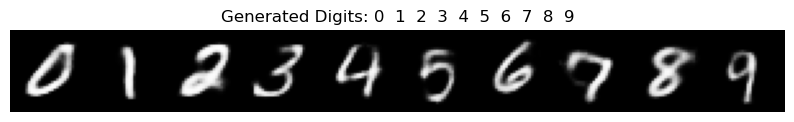

Epoch: 31 - Current Learning Rate: 0.001
====> Epoch: 31 Average training (validation) loss: 96.0471 (98.7077)
EarlyStopping counter: 1 out of 5
Epoch: 32 - Current Learning Rate: 0.001
====> Epoch: 32 Average training (validation) loss: 95.9181 (98.8351)
EarlyStopping counter: 2 out of 5
Epoch: 33 - Current Learning Rate: 0.001
====> Epoch: 33 Average training (validation) loss: 95.7554 (97.8849)
Epoch: 34 - Current Learning Rate: 0.001
====> Epoch: 34 Average training (validation) loss: 95.6452 (98.1529)
EarlyStopping counter: 1 out of 5
Epoch: 35 - Current Learning Rate: 0.001
====> Epoch: 35 Average training (validation) loss: 95.4673 (98.6820)
EarlyStopping counter: 2 out of 5


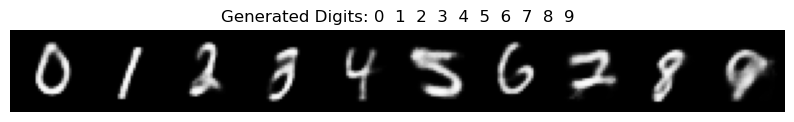

Epoch: 36 - Current Learning Rate: 0.001
====> Epoch: 36 Average training (validation) loss: 95.2824 (98.2880)
EarlyStopping counter: 3 out of 5
Epoch: 37 - Current Learning Rate: 0.001
====> Epoch: 37 Average training (validation) loss: 95.2039 (97.3363)
Epoch: 38 - Current Learning Rate: 0.001
====> Epoch: 38 Average training (validation) loss: 95.0475 (98.3338)
EarlyStopping counter: 1 out of 5
Epoch: 39 - Current Learning Rate: 0.001
====> Epoch: 39 Average training (validation) loss: 95.0001 (97.6938)
EarlyStopping counter: 2 out of 5
Epoch: 40 - Current Learning Rate: 0.001
====> Epoch: 40 Average training (validation) loss: 94.7949 (97.3924)
EarlyStopping counter: 3 out of 5


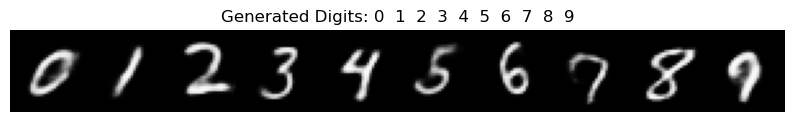

Epoch: 41 - Current Learning Rate: 0.001
====> Epoch: 41 Average training (validation) loss: 94.7053 (97.1187)
Epoch: 42 - Current Learning Rate: 0.001
====> Epoch: 42 Average training (validation) loss: 94.5781 (97.2434)
EarlyStopping counter: 1 out of 5
Epoch: 43 - Current Learning Rate: 0.001
====> Epoch: 43 Average training (validation) loss: 94.4807 (96.7749)
Epoch: 44 - Current Learning Rate: 0.001
====> Epoch: 44 Average training (validation) loss: 94.3066 (97.2275)
EarlyStopping counter: 1 out of 5
Epoch: 45 - Current Learning Rate: 0.001
====> Epoch: 45 Average training (validation) loss: 94.2876 (96.9731)
EarlyStopping counter: 2 out of 5


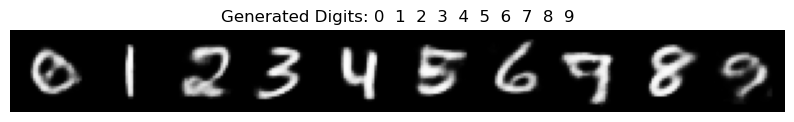

Epoch: 46 - Current Learning Rate: 0.001
====> Epoch: 46 Average training (validation) loss: 94.2123 (97.0259)
EarlyStopping counter: 3 out of 5
Epoch: 47 - Current Learning Rate: 0.001
====> Epoch: 47 Average training (validation) loss: 94.1491 (96.6848)
Epoch: 48 - Current Learning Rate: 0.001
====> Epoch: 48 Average training (validation) loss: 93.9665 (97.0966)
EarlyStopping counter: 1 out of 5
Epoch: 49 - Current Learning Rate: 0.001
====> Epoch: 49 Average training (validation) loss: 93.9143 (96.8544)
EarlyStopping counter: 2 out of 5
Epoch: 50 - Current Learning Rate: 0.001
====> Epoch: 50 Average training (validation) loss: 93.8935 (96.9769)
EarlyStopping counter: 3 out of 5


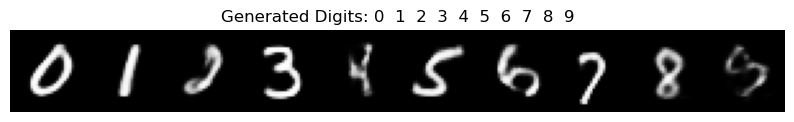

Epoch: 51 - Current Learning Rate: 0.001
====> Epoch: 51 Average training (validation) loss: 93.7529 (96.9577)
EarlyStopping counter: 4 out of 5
Epoch: 52 - Current Learning Rate: 0.0005
====> Epoch: 52 Average training (validation) loss: 92.7902 (95.7995)
Epoch: 53 - Current Learning Rate: 0.0005
====> Epoch: 53 Average training (validation) loss: 92.6294 (95.5398)
Epoch: 54 - Current Learning Rate: 0.0005
====> Epoch: 54 Average training (validation) loss: 92.5452 (95.5470)
EarlyStopping counter: 1 out of 5
Epoch: 55 - Current Learning Rate: 0.0005
====> Epoch: 55 Average training (validation) loss: 92.5157 (95.7966)
EarlyStopping counter: 2 out of 5


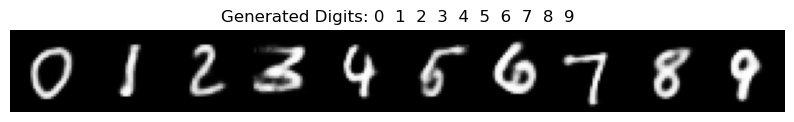

Epoch: 56 - Current Learning Rate: 0.0005
====> Epoch: 56 Average training (validation) loss: 92.4541 (95.4060)
Epoch: 57 - Current Learning Rate: 0.0005
====> Epoch: 57 Average training (validation) loss: 92.4570 (95.5170)
EarlyStopping counter: 1 out of 5
Epoch: 58 - Current Learning Rate: 0.0005
====> Epoch: 58 Average training (validation) loss: 92.4067 (95.4618)
EarlyStopping counter: 2 out of 5
Epoch: 59 - Current Learning Rate: 0.0005
====> Epoch: 59 Average training (validation) loss: 92.3673 (95.3852)
Epoch: 60 - Current Learning Rate: 0.0005
====> Epoch: 60 Average training (validation) loss: 92.3740 (95.4469)
EarlyStopping counter: 1 out of 5


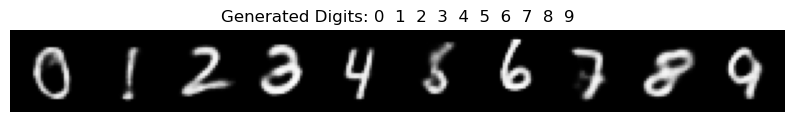

Epoch: 61 - Current Learning Rate: 0.0005
====> Epoch: 61 Average training (validation) loss: 92.3324 (95.3927)
EarlyStopping counter: 2 out of 5
Epoch: 62 - Current Learning Rate: 0.0005
====> Epoch: 62 Average training (validation) loss: 92.2797 (95.4561)
EarlyStopping counter: 3 out of 5
Epoch: 63 - Current Learning Rate: 0.0005
====> Epoch: 63 Average training (validation) loss: 92.2264 (95.5948)
EarlyStopping counter: 4 out of 5
Epoch: 64 - Current Learning Rate: 0.00025
====> Epoch: 64 Average training (validation) loss: 91.7298 (94.9368)
Epoch: 65 - Current Learning Rate: 0.00025
====> Epoch: 65 Average training (validation) loss: 91.6462 (94.8706)


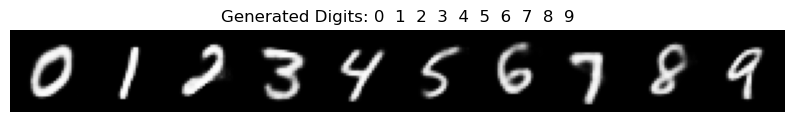

Epoch: 66 - Current Learning Rate: 0.00025
====> Epoch: 66 Average training (validation) loss: 91.6036 (94.8182)
Epoch: 67 - Current Learning Rate: 0.00025
====> Epoch: 67 Average training (validation) loss: 91.6018 (94.8626)
EarlyStopping counter: 1 out of 5
Epoch: 68 - Current Learning Rate: 0.00025
====> Epoch: 68 Average training (validation) loss: 91.5930 (94.8373)
EarlyStopping counter: 2 out of 5
Epoch: 69 - Current Learning Rate: 0.00025
====> Epoch: 69 Average training (validation) loss: 91.6099 (94.8185)
EarlyStopping counter: 3 out of 5
Epoch: 70 - Current Learning Rate: 0.00025
====> Epoch: 70 Average training (validation) loss: 91.5163 (94.8653)
EarlyStopping counter: 4 out of 5


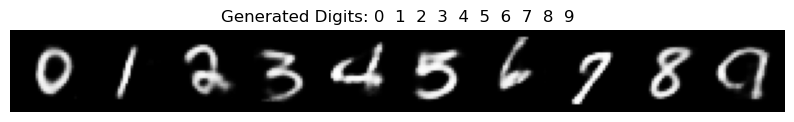

Epoch: 71 - Current Learning Rate: 0.000125
====> Epoch: 71 Average training (validation) loss: 91.2691 (94.6316)
Epoch: 72 - Current Learning Rate: 0.000125
====> Epoch: 72 Average training (validation) loss: 91.2754 (94.6113)
Epoch: 73 - Current Learning Rate: 0.000125
====> Epoch: 73 Average training (validation) loss: 91.1978 (94.6347)
EarlyStopping counter: 1 out of 5
Epoch: 74 - Current Learning Rate: 0.000125
====> Epoch: 74 Average training (validation) loss: 91.2004 (94.5770)
Epoch: 75 - Current Learning Rate: 0.000125
====> Epoch: 75 Average training (validation) loss: 91.1764 (94.6434)
EarlyStopping counter: 1 out of 5


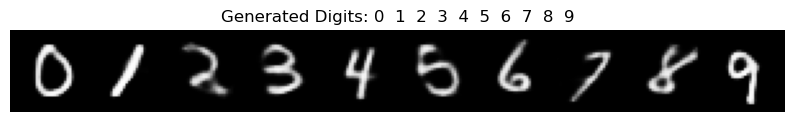

Epoch: 76 - Current Learning Rate: 0.000125
====> Epoch: 76 Average training (validation) loss: 91.2038 (94.5979)
EarlyStopping counter: 2 out of 5
Epoch: 77 - Current Learning Rate: 0.000125
====> Epoch: 77 Average training (validation) loss: 91.1639 (94.5557)
Epoch: 78 - Current Learning Rate: 0.000125
====> Epoch: 78 Average training (validation) loss: 91.1491 (94.5463)
Epoch: 79 - Current Learning Rate: 0.000125
====> Epoch: 79 Average training (validation) loss: 91.1163 (94.5741)
EarlyStopping counter: 1 out of 5
Epoch: 80 - Current Learning Rate: 0.000125
====> Epoch: 80 Average training (validation) loss: 91.1502 (94.5731)
EarlyStopping counter: 2 out of 5


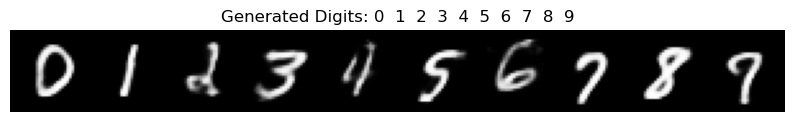

Epoch: 81 - Current Learning Rate: 0.000125
====> Epoch: 81 Average training (validation) loss: 91.1337 (94.5375)
Epoch: 82 - Current Learning Rate: 0.000125
====> Epoch: 82 Average training (validation) loss: 91.1272 (94.5454)
EarlyStopping counter: 1 out of 5
Epoch: 83 - Current Learning Rate: 0.000125
====> Epoch: 83 Average training (validation) loss: 91.0999 (94.5303)
Epoch: 84 - Current Learning Rate: 0.000125
====> Epoch: 84 Average training (validation) loss: 91.1202 (94.6343)
EarlyStopping counter: 1 out of 5
Epoch: 85 - Current Learning Rate: 0.000125
====> Epoch: 85 Average training (validation) loss: 91.0622 (94.5170)


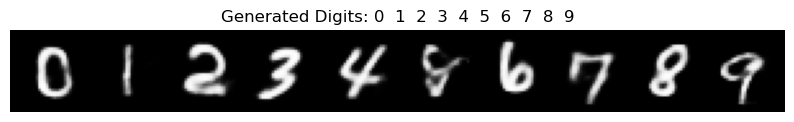

Epoch: 86 - Current Learning Rate: 0.000125
====> Epoch: 86 Average training (validation) loss: 91.0964 (94.5537)
EarlyStopping counter: 1 out of 5
Epoch: 87 - Current Learning Rate: 0.000125
====> Epoch: 87 Average training (validation) loss: 91.0696 (94.4530)
Epoch: 88 - Current Learning Rate: 0.000125
====> Epoch: 88 Average training (validation) loss: 91.0555 (94.5589)
EarlyStopping counter: 1 out of 5
Epoch: 89 - Current Learning Rate: 0.000125
====> Epoch: 89 Average training (validation) loss: 91.0680 (94.5892)
EarlyStopping counter: 2 out of 5
Epoch: 90 - Current Learning Rate: 0.000125
====> Epoch: 90 Average training (validation) loss: 91.0239 (94.5424)
EarlyStopping counter: 3 out of 5


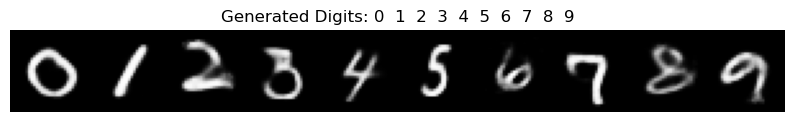

Epoch: 91 - Current Learning Rate: 0.000125
====> Epoch: 91 Average training (validation) loss: 91.0145 (94.5724)
EarlyStopping counter: 4 out of 5
Epoch: 92 - Current Learning Rate: 6.25e-05
====> Epoch: 92 Average training (validation) loss: 90.9063 (94.4079)
Epoch: 93 - Current Learning Rate: 6.25e-05
====> Epoch: 93 Average training (validation) loss: 90.8779 (94.4541)
EarlyStopping counter: 1 out of 5
Epoch: 94 - Current Learning Rate: 6.25e-05
====> Epoch: 94 Average training (validation) loss: 90.8670 (94.4025)
Epoch: 95 - Current Learning Rate: 6.25e-05
====> Epoch: 95 Average training (validation) loss: 90.8641 (94.4677)
EarlyStopping counter: 1 out of 5


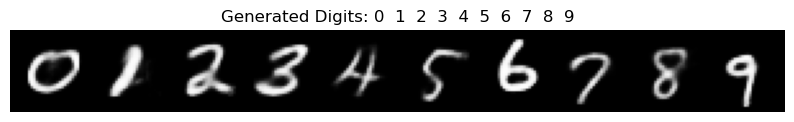

Epoch: 96 - Current Learning Rate: 6.25e-05
====> Epoch: 96 Average training (validation) loss: 90.8594 (94.4315)
EarlyStopping counter: 2 out of 5
Epoch: 97 - Current Learning Rate: 3.125e-05
====> Epoch: 97 Average training (validation) loss: 90.7785 (94.2975)
Epoch: 98 - Current Learning Rate: 3.125e-05
====> Epoch: 98 Average training (validation) loss: 90.7443 (94.3562)
EarlyStopping counter: 1 out of 5
Epoch: 99 - Current Learning Rate: 3.125e-05
====> Epoch: 99 Average training (validation) loss: 90.7466 (94.3280)
EarlyStopping counter: 2 out of 5
Epoch: 100 - Current Learning Rate: 3.125e-05
====> Epoch: 100 Average training (validation) loss: 90.7582 (94.3443)
EarlyStopping counter: 3 out of 5


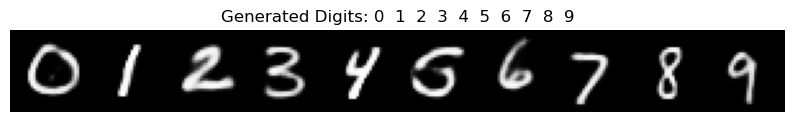

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_dim = 30
label_dim = 10  # 10 labels in MNIST
hidden_dim = 400

model = CVAE(latent_dim, label_dim, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


early_stopping = EarlyStopping(patience=5, verbose=True)

    
def train(epoch):
    model.train()
    train_loss = 0
    
    stop = False
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float32, device=device)
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data, labels)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')

    avg_train_loss = train_loss / len(train_loader.dataset)
    
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    with torch.no_grad():  # No gradients needed
        for data, labels in val_loader:
            data = data.view(data.size(0), -1).to(device)
            labels = F.one_hot(labels, num_classes=10).to(dtype=torch.float32, device=device)
            recon, mu, log_var = model(data, labels)
            loss = loss_function(recon, data, mu, log_var)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader.dataset)
    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch: {epoch} - Current Learning Rate: {current_lr}')

    print(f'====> Epoch: {epoch} Average training (validation) loss: {avg_train_loss:.4f} ({avg_val_loss:.4f})')

    scheduler.step(avg_val_loss)  

    
    # Call to the early stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        stop = True

    return avg_train_loss, avg_val_loss, current_lr, stop


def generate_images(model, epoch, condition_labels=torch.eye(10)):
    with torch.no_grad():
        model.eval()
        z = torch.randn((10, latent_dim)).to(device)  # Generate random latent vectors
        labels = condition_labels.to(device)  # One-hot encoded labels for each digit 0-9
        generated_images = model.decoder(z, labels).view(-1, 1, 28, 28)
        generated_images = generated_images.cpu()  # Move images to CPU for visualization

        fig, ax = plt.subplots(figsize=(10, 2))
        grid = torchvision.utils.make_grid(generated_images, nrow=10)
        ax.imshow(grid.permute(1, 2, 0))
        ax.axis('off')

        # Display labels below images
        labels_text = labels.argmax(dim=1).cpu().numpy()  # Convert labels to actual digits
        ax.set_title('Generated Digits: ' + '  '.join(str(digit) for digit in labels_text))
        plt.show()


num_epochs = 100
train_losses, val_losses, learning_rate = [], [],  []
for epoch in range(1, num_epochs + 1):
    t_loss, v_loss, lr, stop = train(epoch)        
    train_losses.append(t_loss)
    val_losses.append(v_loss)
    learning_rate.append(lr)
    
    if epoch % 5 == 0:  # Generate images every 2 epochs
        generate_images(model, epoch)
    if stop: break



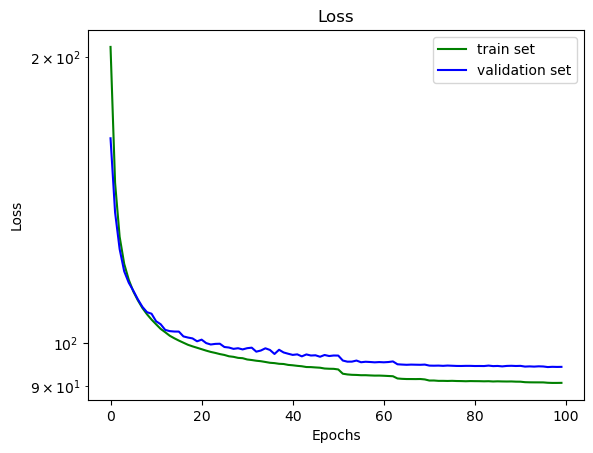

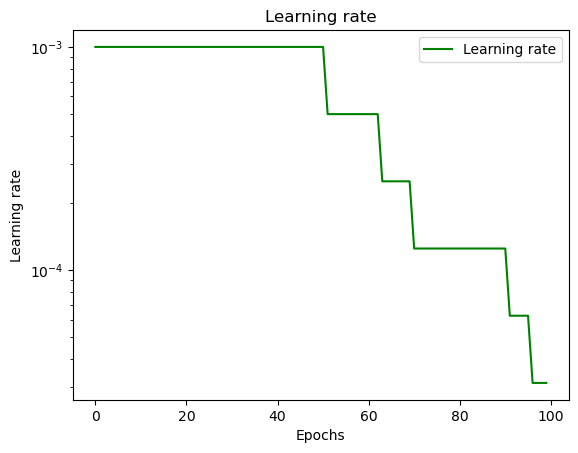

In [66]:
plt.plot(range(len(train_losses)), train_losses, label="train set", color="green")
plt.plot(range(len(val_losses)), val_losses, label="validation set", color="blue")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss")
plt.yscale('log')

plt.legend()
plt.show()

plt.plot(range(len(learning_rate)), learning_rate, label="Learning rate", color="green")

plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate")
plt.yscale('log')

plt.legend()
plt.show()


Real  0


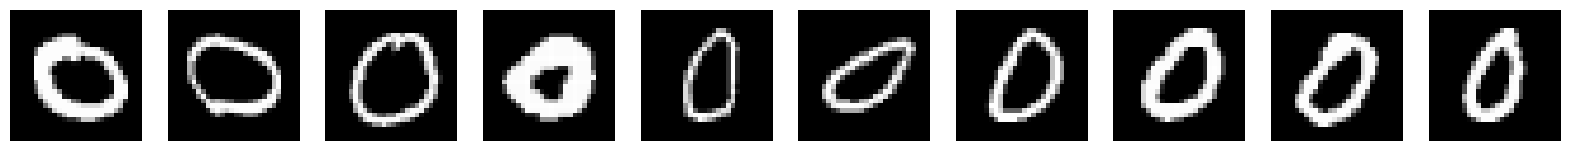

Generated  0


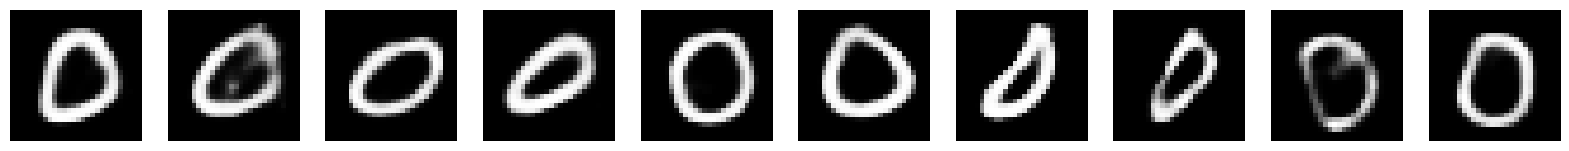

Real  1


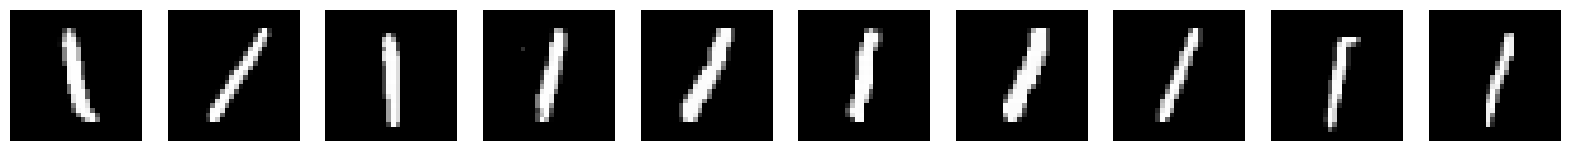

Generated  1


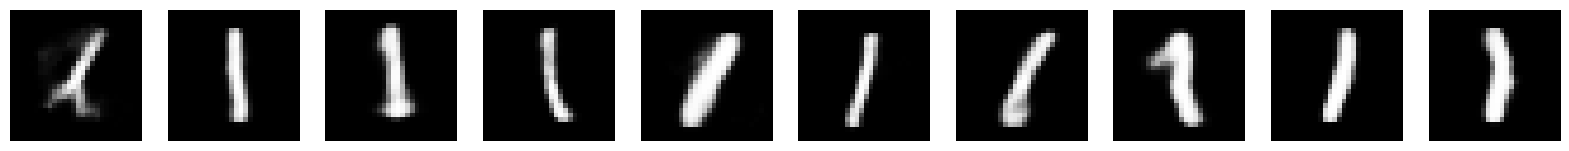

Real  2


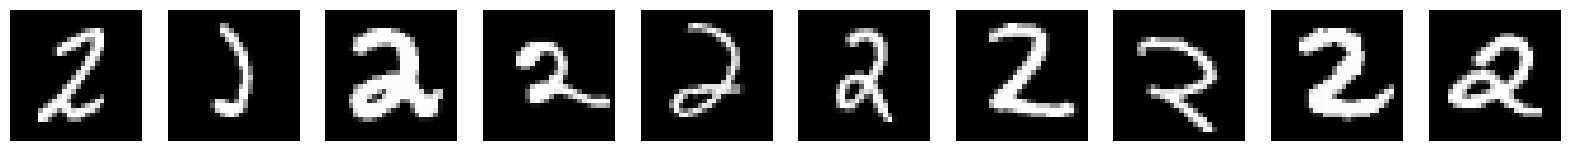

Generated  2


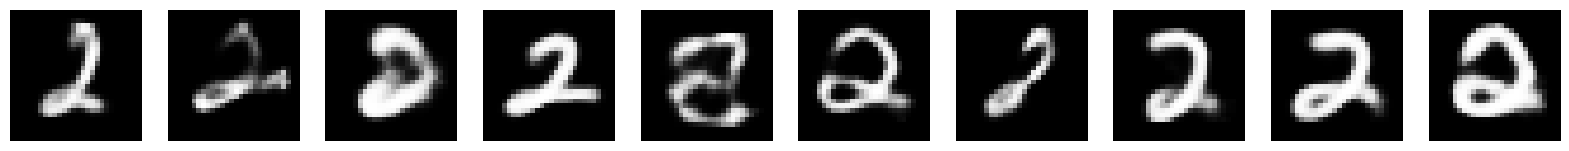

Real  3


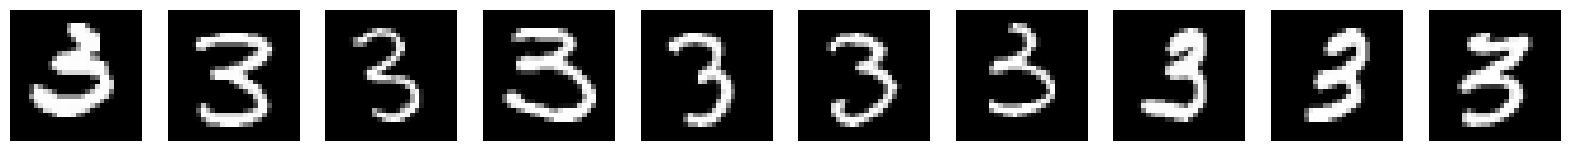

Generated  3


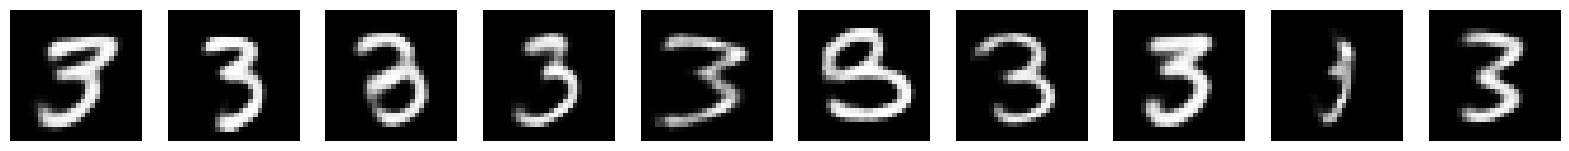

Real  4


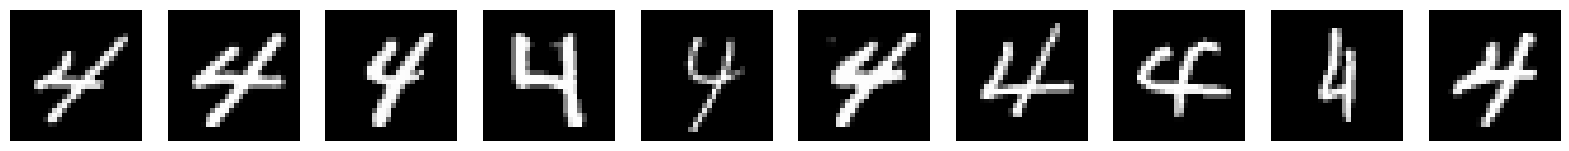

Generated  4


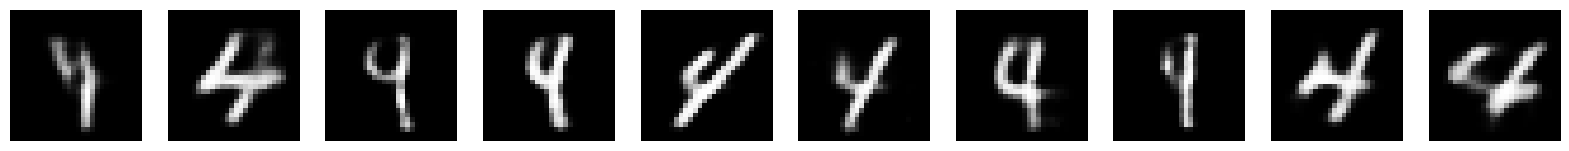

Real  5


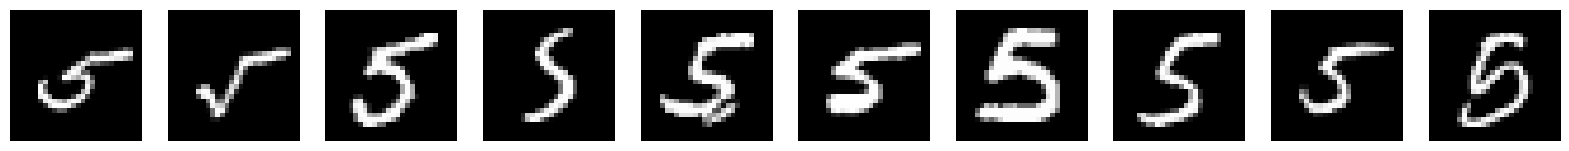

Generated  5


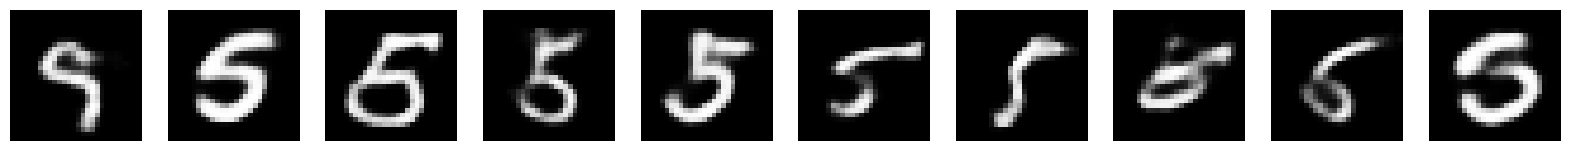

Real  6


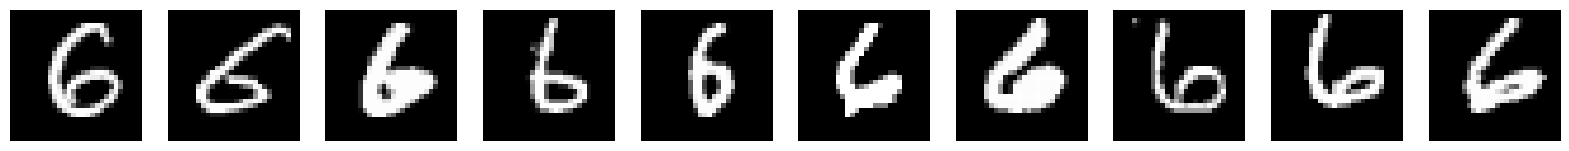

Generated  6


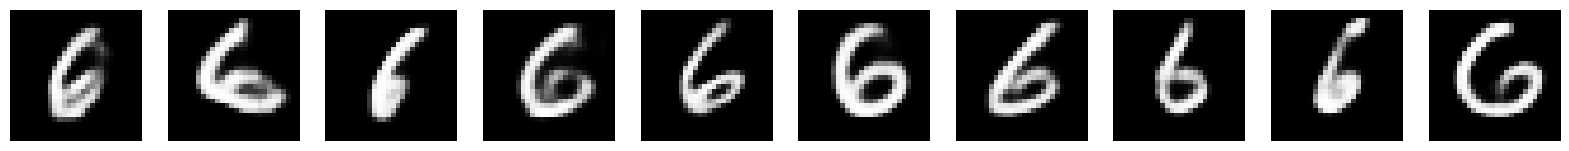

Real  7


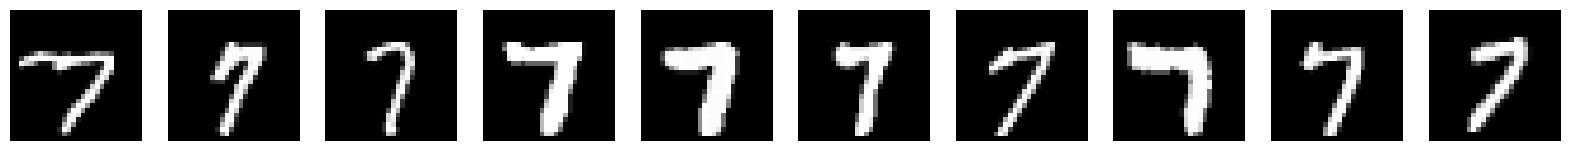

Generated  7


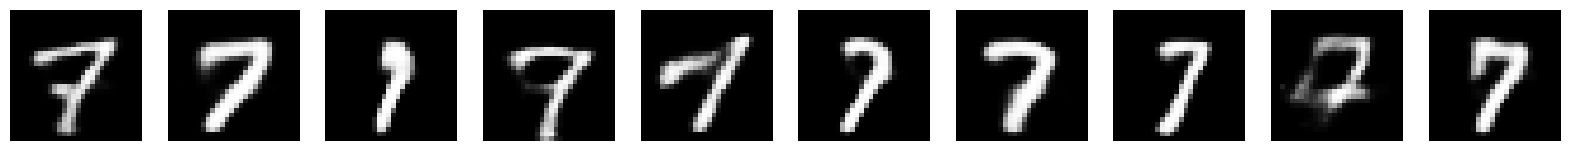

Real  8


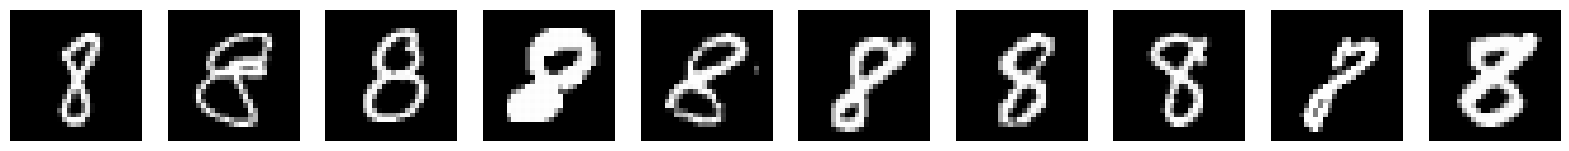

Generated  8


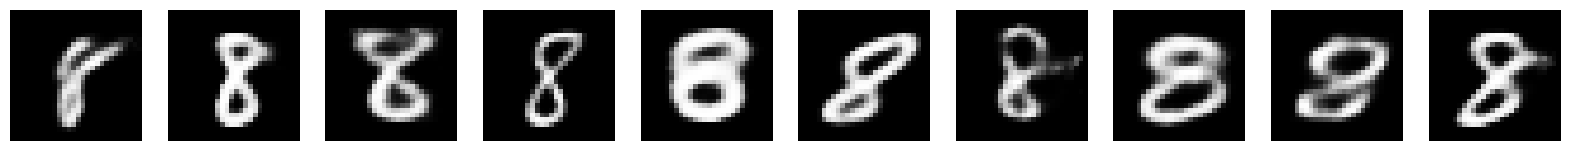

Real  9


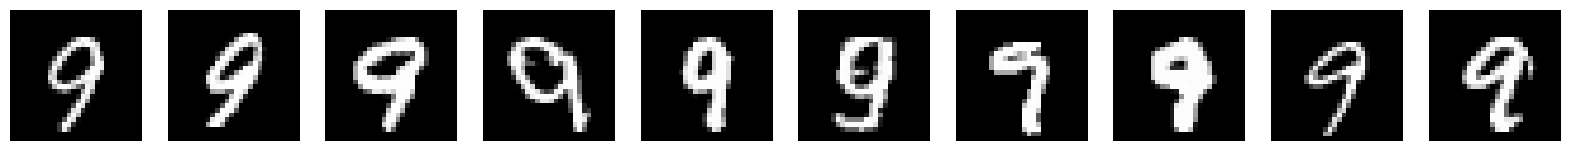

Generated  9


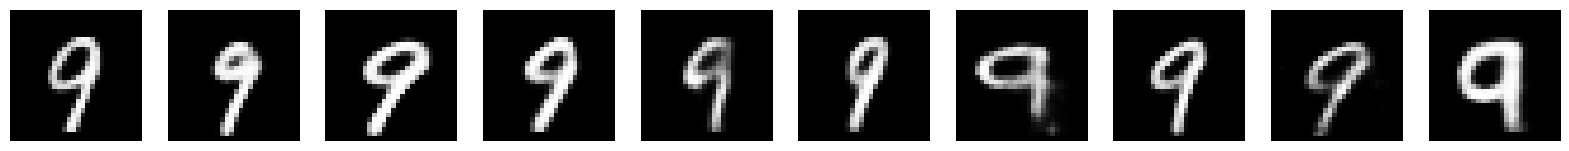

In [72]:
def generate_and_display_images(model, device, label, num_images=10):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Ensures no gradients are calculated
        # Create latent vectors
        z = torch.randn(num_images, 30).to(device)  # Adjust latent_dim to 30
        # Create one-hot encoded label tensors
        labels = torch.zeros(num_images, 10).to(device)
        labels[:, label] = 1
        
        # Generate images
        generated_images = model.decoder(z, labels).view(num_images, 1, 28, 28)
        
        # Plotting
        fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i, img in enumerate(generated_images.cpu()):
            axs[i].imshow(img.squeeze(), cmap='gray')
            axs[i].axis('off')
        plt.show()

def display_real_images(data_loader, label, num_images=10):
    plt.figure(figsize=(num_images * 2, 2))  # Set the figure size to accommodate all images in one row
    count = 0  # To count the number of images plotted

    for data, targets in data_loader:
        for i in range(data.size(0)):
            if targets[i] == label:
                img = data[i].squeeze()  # Remove channel dimension if it's single channel (grayscale)
                plt.subplot(1, num_images, count + 1)  # Subplot for each image in a row
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                count += 1
                if count == num_images:
                    plt.show()
                    return  # Exit once we have displayed the required number of images
    plt.show()  # Show any collected images if we didn't reach the required number before the end of the loop

for label in range(0, 10):
    print("Real ", label)
    display_real_images(val_loader, label)
    print("Generated ", label)
    generate_and_display_images(model, device, label)
    